&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../START_HERE.ipynb)

[Previous Notebook](04-Challenge.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](01-Intro_to_Dask.ipynb)
[2](02-CuDF_and_Dask.ipynb)
[3](03-CuML_and_Dask.ipynb)
[4](04-Challenge.ipynb)
[5]

# K-Means Challenge - Solution

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information about cuDF, refer to the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable).

For additional information on cuML's k-means implementation: https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans.

The given solution implements CuML on a single GPU. Your task is to convert the entire code using Dask so that it can run on Multi-node, Multi-GPU systems. Your coding task begins <a href='#task1'>here</a>.

## Imports

Let's begin by importing the libraries necessary for this implementation.

In [1]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

## Define Parameters

Here we will define the data and model parameters which will be used while generating data and building our model. You can change these parameters and observe the change in the results.

In [2]:
n_samples = 100000
n_features = 2

n_clusters = 5
random_state = 0

## Generate Data

Generate isotropic Gaussian blobs for clustering.

In [3]:
device_data, device_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        random_state=random_state,
                                        cluster_std=0.1)

device_data = cudf.DataFrame(device_data)
device_labels = cudf.Series(device_labels)

In [4]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
host_data = device_data.to_pandas()
host_labels = device_labels.to_pandas()

## Scikit-learn model

Here we will use Scikit-learn to define our model. The arguments to the model include:

- n_clusters: int, default=8
The number of clusters to form as well as the number of centroids to generate.

- init{‘k-means++’, ‘random’}, callable or array-like of shape (n_clusters, n_features), default=’k-means++’
Method for initialization:

- ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
- max_iterint, default=300
Maximum number of iterations of the k-means algorithm for a single run.

- random_state: int, RandomState instance or None, default=None
Determines random number generation for centroid initialization. Use an int to make the randomness deterministic. .

- n_jobs: int, default=None
The number of OpenMP threads to use for the computation. Parallelism is sample-wise on the main cython loop which assigns each sample to its closest center. None or -1 means using all processors.

### Fit

In [5]:
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                     n_jobs=-1,
                    random_state=random_state)

kmeans_sk.fit(host_data)

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


CPU times: user 42 s, sys: 1.77 s, total: 43.8 s
Wall time: 731 ms


KMeans(n_clusters=5, n_jobs=-1, random_state=0)

## cuML Model

### Fit

In [6]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=40,
                       random_state=random_state)

kmeans_cuml.fit(device_data)

CPU times: user 2.45 s, sys: 86.8 ms, total: 2.53 s
Wall time: 36.1 ms


KMeans(handle=<cuml.raft.common.handle.Handle object at 0x7f0d5b7a0bb0>, n_clusters=5, max_iter=300, tol=0.0001, verbose=4, random_state=0, init='k-means||', n_init=1, oversampling_factor=40, max_samples_per_batch=32768, output_type='cudf')

## Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means||`. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: Visualizing the centroids will only work when `n_features = 2` 

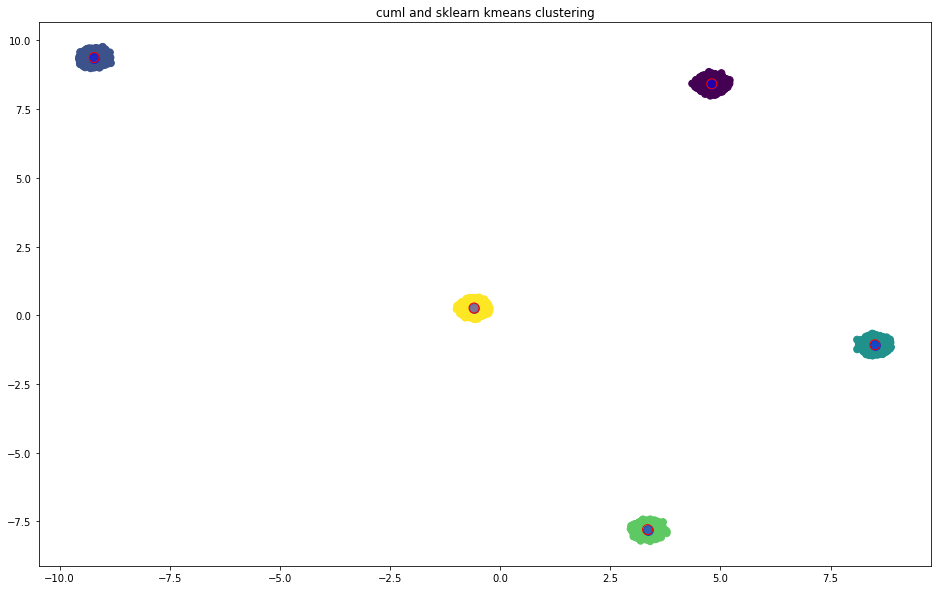

In [7]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values), 
            cupy.asnumpy(centers_cuml[1].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

## Compare Results

In [8]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.to_array())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 27.5 ms, sys: 961 µs, total: 28.4 ms
Wall time: 27.7 ms


In [9]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal


<a id='task1'></a>

# K-Means Multi-Node Multi-GPU (MNMG) Solution

K-Means multi-Node multi-GPU implementation leverages Dask to spread data and computations across multiple workers. cuML uses One Process Per GPU (OPG) layout, which maps a single Dask worker to each GPU.

The main difference between cuML's MNMG implementation of k-means and the single-GPU is that the fit can be performed in parallel for each iteration, sharing only the centroids between iterations. The MNMG version also provides the same scalable k-means++ initialization algorithm as the single-GPU version.

Unlike the single-GPU implementation, The MNMG k-means API requires a Dask Dataframe or Array as input. `predict()` and `transform()` return the same type as input. The Dask cuDF Dataframe API is very similar to the Dask DataFrame API, but underlying Dataframes are cuDF, rather than Pandas. Dask cuPy arrays are also available.

For information about cuDF, refer to the [cuDF documentation](https://docs.rapids.ai/api/cudf/stable).

For additional information on cuML's k-means implementation: 
https://docs.rapids.ai/api/cuml/stable/api.html#cuml.dask.cluster.KMeans.

## Imports

Let's begin by importing the libraries necessary for this implementation.

In [1]:
from cuml.dask.cluster.kmeans import KMeans as cuKMeans
from cuml.dask.common import to_dask_df
from cuml.dask.datasets import make_blobs
from cuml.metrics import adjusted_rand_score
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from dask_ml.cluster import KMeans as skKMeans
import cupy as cp

## Start Dask Cluster

We can use the `LocalCUDACluster` to start a Dask cluster on a single machine with one worker mapped to each GPU. This is called one-process-per-GPU (OPG). 

In [2]:
cluster = LocalCUDACluster(threads_per_worker=1)
client = Client(cluster)

/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33117 instead
  http_address["port"], self.http_server.port


## Define Parameters

Here we will define the data and model parameters which will be used while generating data and building our model. You can change these parameters and observe the change in the results.

In [3]:
n_samples = 1000000
n_features = 2

n_total_partitions = len(list(client.has_what().keys()))

## Generate Data

Generate isotropic Gaussian blobs for clustering.

### Device

We can generate a Dask cuPY Array of synthetic data for multiple clusters using `cuml.dask.datasets.make_blobs`.

In [4]:
X_dca, Y_dca = make_blobs(n_samples, 
                          n_features,
                          centers = 5, 
                          n_parts = n_total_partitions,
                          cluster_std=0.1, 
                          verbose=True)

### Host

We collect the Dask cuPy Array on a single node as a cuPy array. Then we transfer the cuPy array from device to host memory into a Numpy array.

In [5]:
X_cp = X_dca.compute()
X_np = cp.asnumpy(X_cp)
del X_cp

## Scikit-learn model

The arguments to the model object include:

- n_clusters: int, default=8
The number of clusters to form as well as the number of centroids to generate.

- init{‘k-means++’, ‘random’}, callable or array-like of shape (n_clusters, n_features), default=’k-means++’
Method for initialization:

- ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
- max_iterint, default=300
Maximum number of iterations of the k-means algorithm for a single run.

- random_state: int, RandomState instance or None, default=None
Determines random number generation for centroid initialization. Use an int to make the randomness deterministic. .

- n_jobs: int, default=None
The number of OpenMP threads to use for the computation. Parallelism is sample-wise on the main cython loop which assigns each sample to its closest center. None or -1 means using all processors.

### Fit and predict

Since a scikit-learn equivalent to the multi-node multi-GPU K-means in cuML doesn't exist, we will use Dask-ML's implementation for comparison.

In [6]:
%%time
kmeans_sk = skKMeans(init="k-means||",
                     n_clusters=5,
                     n_jobs=-1,
                     random_state=100)

kmeans_sk.fit(X_np)

CPU times: user 9.07 s, sys: 442 ms, total: 9.51 s
Wall time: 18 s


KMeans(n_clusters=5, n_jobs=-1, random_state=100)

In [7]:
%%time
labels_sk = kmeans_sk.predict(X_np).compute()

CPU times: user 340 ms, sys: 22.6 ms, total: 362 ms
Wall time: 544 ms


## cuML Model

### Fit and predict

In [8]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=5,
                       random_state=100)

kmeans_cuml.fit(X_dca)

CPU times: user 25.2 ms, sys: 4.1 ms, total: 29.3 ms
Wall time: 130 ms


In [9]:
%%time
labels_cuml = kmeans_cuml.predict(X_dca).compute()

CPU times: user 28.3 ms, sys: 2.86 ms, total: 31.2 ms
Wall time: 255 ms


## Compare Results

In [10]:
score = adjusted_rand_score(labels_sk, labels_cuml)

In [11]:
passed = score == 1.0
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal


## Conclusion

Using Dask, we were able to reduce the computation time from 18 seconds to 130 milliseconds, which is around 140th of the time. Thus we have learnt how to effectively use Dask to optimize and accelerate our data science pipeline. If you want to explore Dask in detail, refer to the documentation [here](https://docs.dask.org/en/latest/).

## Licensing
  
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0).

[Previous Notebook](04-Challenge.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](01-Intro_to_Dask.ipynb)
[2](02-CuDF_and_Dask.ipynb)
[3](03-CuML_and_Dask.ipynb)
[4](04-Challenge.ipynb)
[5]
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../START_HERE.ipynb)